In [38]:
from collections import Counter
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import seaborn as sns
from itertools import chain
from scipy.stats import skew, kurtosis


##Import any other packages you may need here

In [39]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
6423,00001730_003.png,Infiltration,3,1730,44,M,PA,2992,2991,0.143,0.143,NaN
97323,00025664_044.png,Effusion,44,25664,72,M,AP,3056,2544,0.139,0.139,NaN
63333,00015646_005.png,No Finding,5,15646,65,M,PA,2718,2991,0.143,0.143,NaN


In [40]:
data_sample = pd.read_csv('sample-labels-ii/sample_labels.csv')
data_sample.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
170,00000996_001.png,No Finding,1,996,040Y,M,PA,3056,2544,0.139,0.139
4693,00023816_000.png,No Finding,0,23816,028Y,M,PA,2726,2783,0.143,0.143
3457,00017064_005.png,Mass,5,17064,069Y,M,PA,2048,2500,0.168,0.168


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Also, **describe your findings and how will you set up the model training based on the findings.**

# EDA 

### Frequency of findings

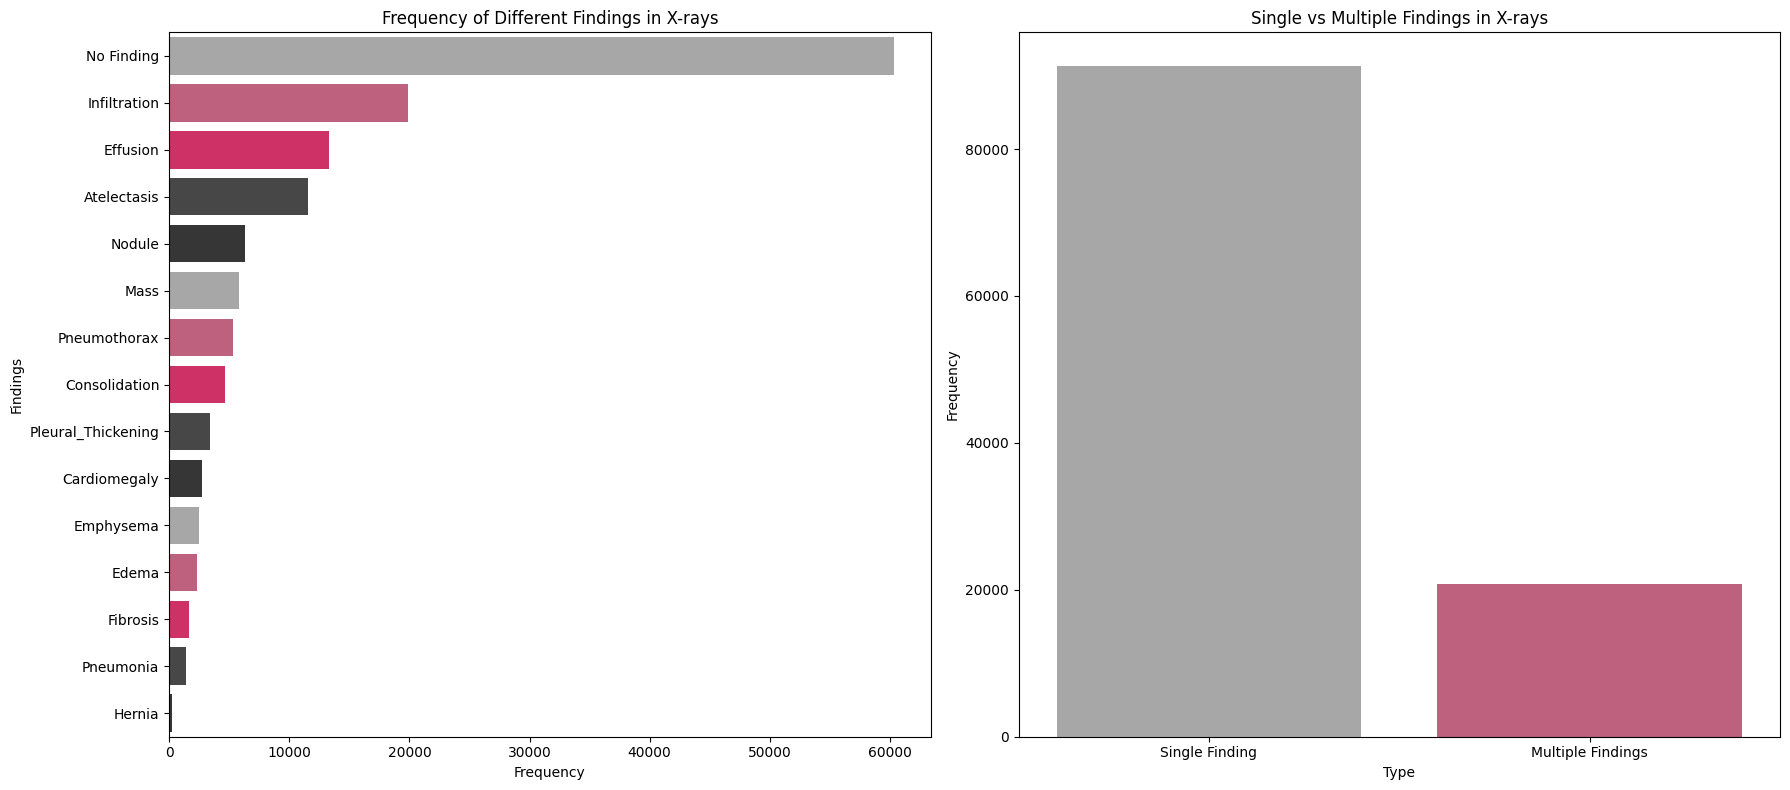

In [41]:
# Define your custom color palette
custom_palette = ['#A8A7A7', '#CC527A', '#E8175D', '#474747','#363636']

# Load the dataset
data_entry_df =  all_xray_df.copy()

# Splitting the findings labels and counting each occurrence
all_labels = data_entry_df['Finding Labels'].str.split('|')
all_findings = Counter(label for labels in all_labels for label in labels)

# Creating a DataFrame from the findings
findings_df = pd.DataFrame.from_dict(all_findings, orient='index').reset_index()
findings_df = findings_df.rename(columns={'index': 'Finding', 0: 'Count'})
findings_df = findings_df.sort_values('Count', ascending=False)

# Checking for co-occurrences of findings
multiple_findings_count = sum(len(labels) > 1 for labels in all_labels)
total_images = len(data_entry_df)
single_findings_count = total_images - multiple_findings_count

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Plotting the frequency of findings with the custom color palette
sns.barplot(x='Count', y='Finding', data=findings_df, ax=axes[0], palette=custom_palette)
axes[0].set_title('Frequency of Different Findings in X-rays')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Findings')

# Plotting the co-occurrence of findings with the custom color palette
sns.barplot(x=['Single Finding', 'Multiple Findings'], y=[single_findings_count, multiple_findings_count], ax=axes[1], palette=custom_palette)
axes[1].set_title('Single vs Multiple Findings in X-rays')
axes[1].set_xlabel('Type')
axes[1].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


### Demographic Insights: Analyzing X-ray Findings Across Gender and Age Groups

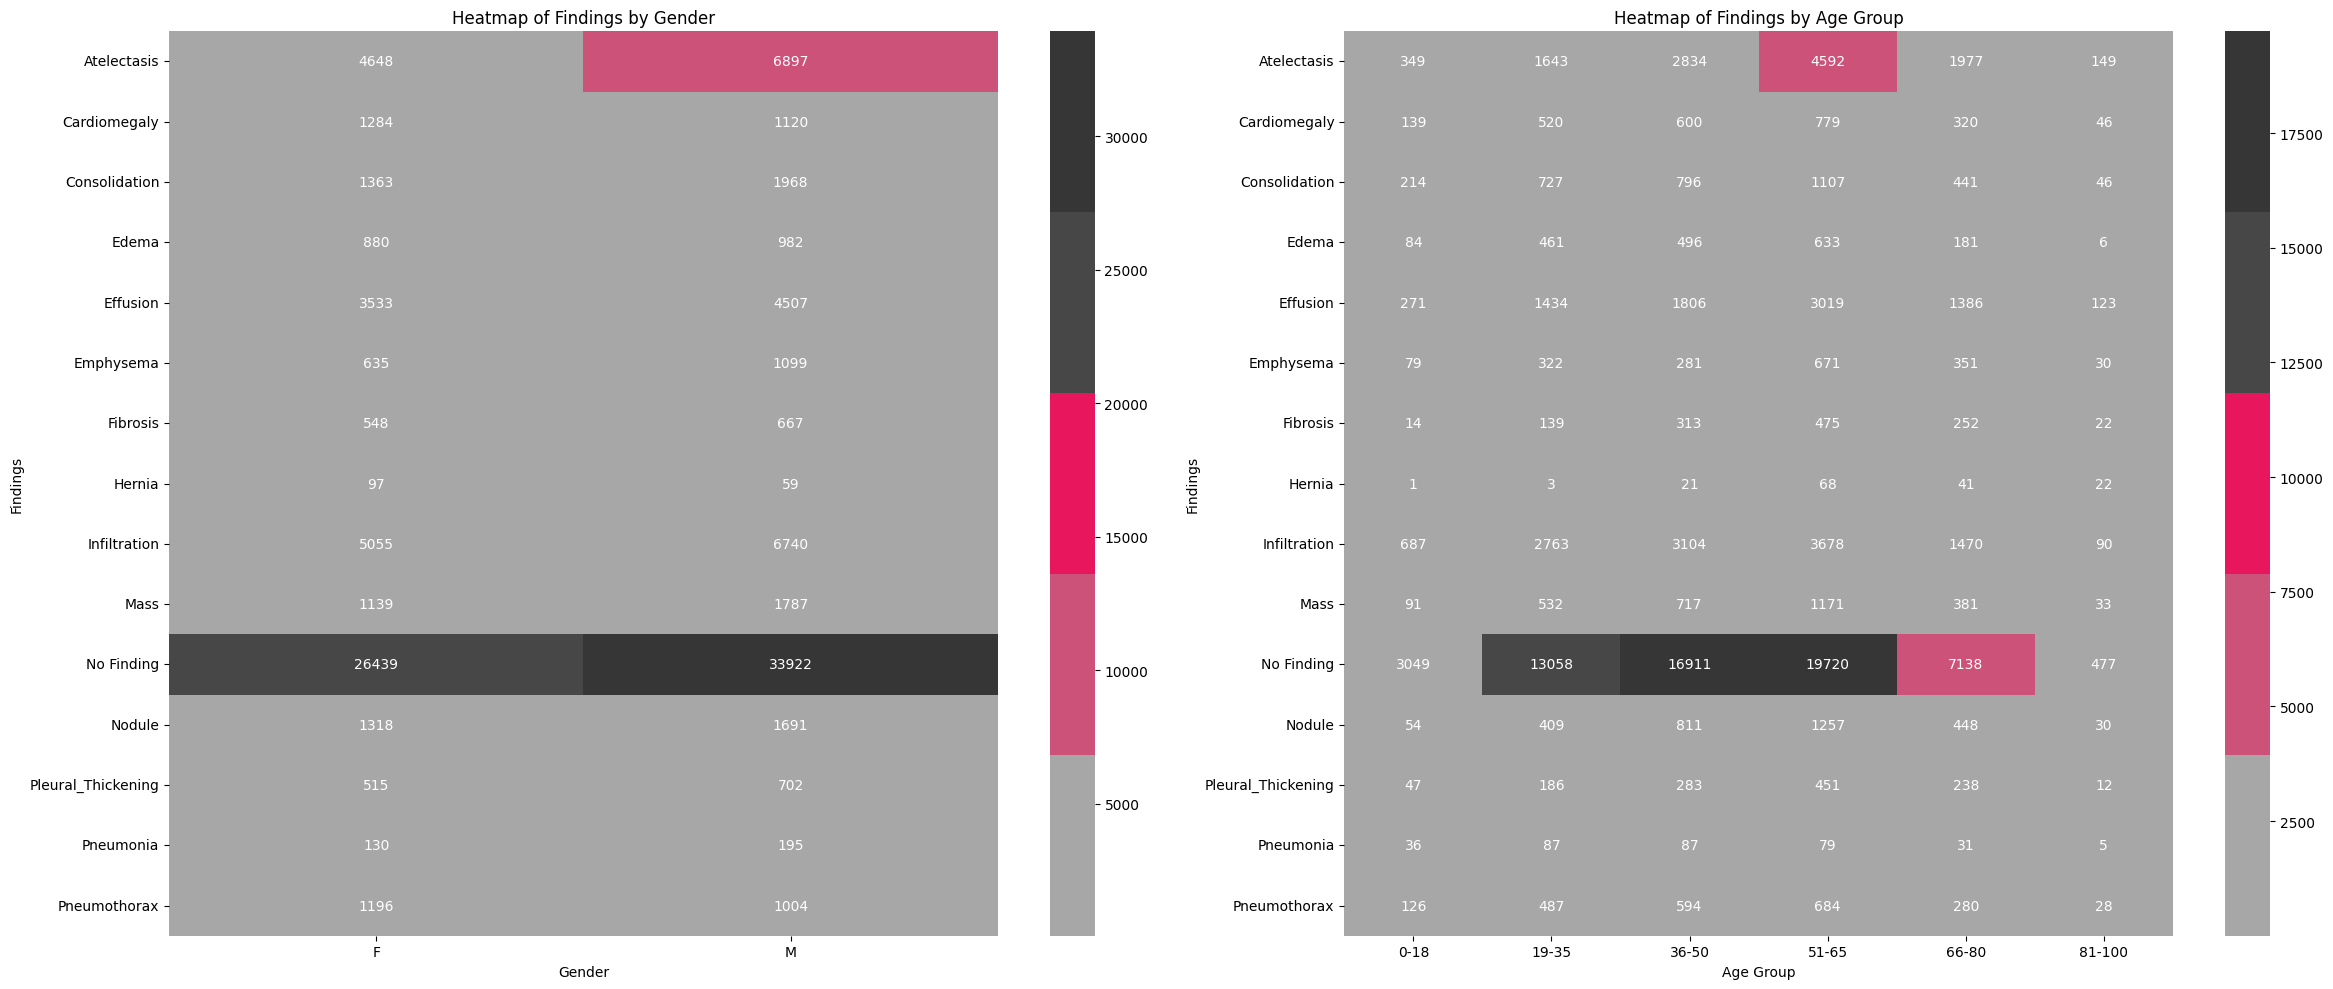

In [42]:
# Define your custom color palette
custom_palette = ['#A8A7A7', '#CC527A', '#E8175D', '#474747','#363636']

# Preparing data for the first heatmap (Findings by Gender)
split_findings_gender = data_entry_df['Finding Labels'].str.split('|', expand=True)
long_findings_gender = split_findings_gender.melt(value_name='Finding').drop('variable', axis=1).dropna()
merged_df_gender = pd.merge(long_findings_gender, data_entry_df[['Image Index', 'Patient Gender']], left_index=True, right_index=True)
heatmap_data_gender = pd.pivot_table(merged_df_gender, values='Image Index', index='Finding', columns='Patient Gender', aggfunc='count')

# Binning the ages into categories for the second heatmap (Findings by Age Group)
bins = [0, 18, 35, 50, 65, 80, 100]
labels = ['0-18', '19-35', '36-50', '51-65', '66-80', '81-100']
data_entry_df['Age Group'] = pd.cut(data_entry_df['Patient Age'], bins=bins, labels=labels, right=False)

# Preparing data for the second heatmap
split_findings_age = data_entry_df['Finding Labels'].str.split('|', expand=True)
long_findings_age = split_findings_age.melt(value_name='Finding').drop('variable', axis=1).dropna()
merged_df_age = pd.merge(long_findings_age, data_entry_df[['Image Index', 'Age Group']], left_index=True, right_index=True)
heatmap_data_age = pd.pivot_table(merged_df_age, values='Image Index', index='Finding', columns='Age Group', aggfunc='count')

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))

# Plotting the first heatmap (Findings by Gender)
sns.heatmap(heatmap_data_gender, annot=True, fmt='d', cmap=sns.color_palette(custom_palette), ax=axes[0])
axes[0].set_title('Heatmap of Findings by Gender')
axes[0].set_ylabel('Findings')
axes[0].set_xlabel('Gender')

# Plotting the second heatmap (Findings by Age Group)
sns.heatmap(heatmap_data_age, annot=True, fmt='d', cmap=sns.color_palette(custom_palette), ax=axes[1])
axes[1].set_title('Heatmap of Findings by Age Group')
axes[1].set_ylabel('Findings')
axes[1].set_xlabel('Age Group')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()


In [70]:
# Load 'sample_labels.csv' data for pixel level assessments
sample_df = data_sample.copy()

# Extract unique labels
all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]

# Create binary columns for each label
for label in all_labels:
    sample_df[label] = sample_df['Finding Labels'].map(lambda finding: 1 if label in finding else 0)

# Define the base path to your dataset
base_path = '/kaggle/input/data'

# Define a pattern to find all image files within the dataset
pattern = os.path.join(base_path, 'images_*', '*', '*.png')

# Use glob to get a list of all image files
sample_df_paths = {os.path.basename(x): x for x in glob(pattern)}

# Update the 'path' column in the DataFrame
sample_df['path'] = sample_df['Image Index'].map(sample_df_paths.get)

# Print the number of scans found and total headers in the DataFrame
print('Scans found:', len(sample_df_paths), ', Total Headers', sample_df.shape[0])


Scans found: 112120 , Total Headers 5606


In [78]:
sample_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,...,0,0,1,0,0,0,1,0,1,/kaggle/input/data/images_001/images/00000013_...
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,...,0,0,0,0,0,0,0,0,0,/kaggle/input/data/images_001/images/00000013_...
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,...,0,0,0,0,1,0,0,0,0,/kaggle/input/data/images_001/images/00000017_...
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,...,0,0,0,0,0,0,0,0,0,/kaggle/input/data/images_001/images/00000030_...
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,...,0,0,0,0,0,0,0,0,0,/kaggle/input/data/images_001/images/00000032_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,...,0,0,0,0,1,0,0,0,0,/kaggle/input/data/images_012/images/00030712_...
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,...,0,0,0,0,0,0,0,0,0,/kaggle/input/data/images_012/images/00030786_...
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,...,0,0,1,0,0,0,0,0,0,/kaggle/input/data/images_012/images/00030789_...
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,...,0,0,0,0,1,0,0,0,0,/kaggle/input/data/images_012/images/00030792_...


### Exploring Pneumonia through X-Ray Imaging: A Combined Visual and Histogramatic Perspective

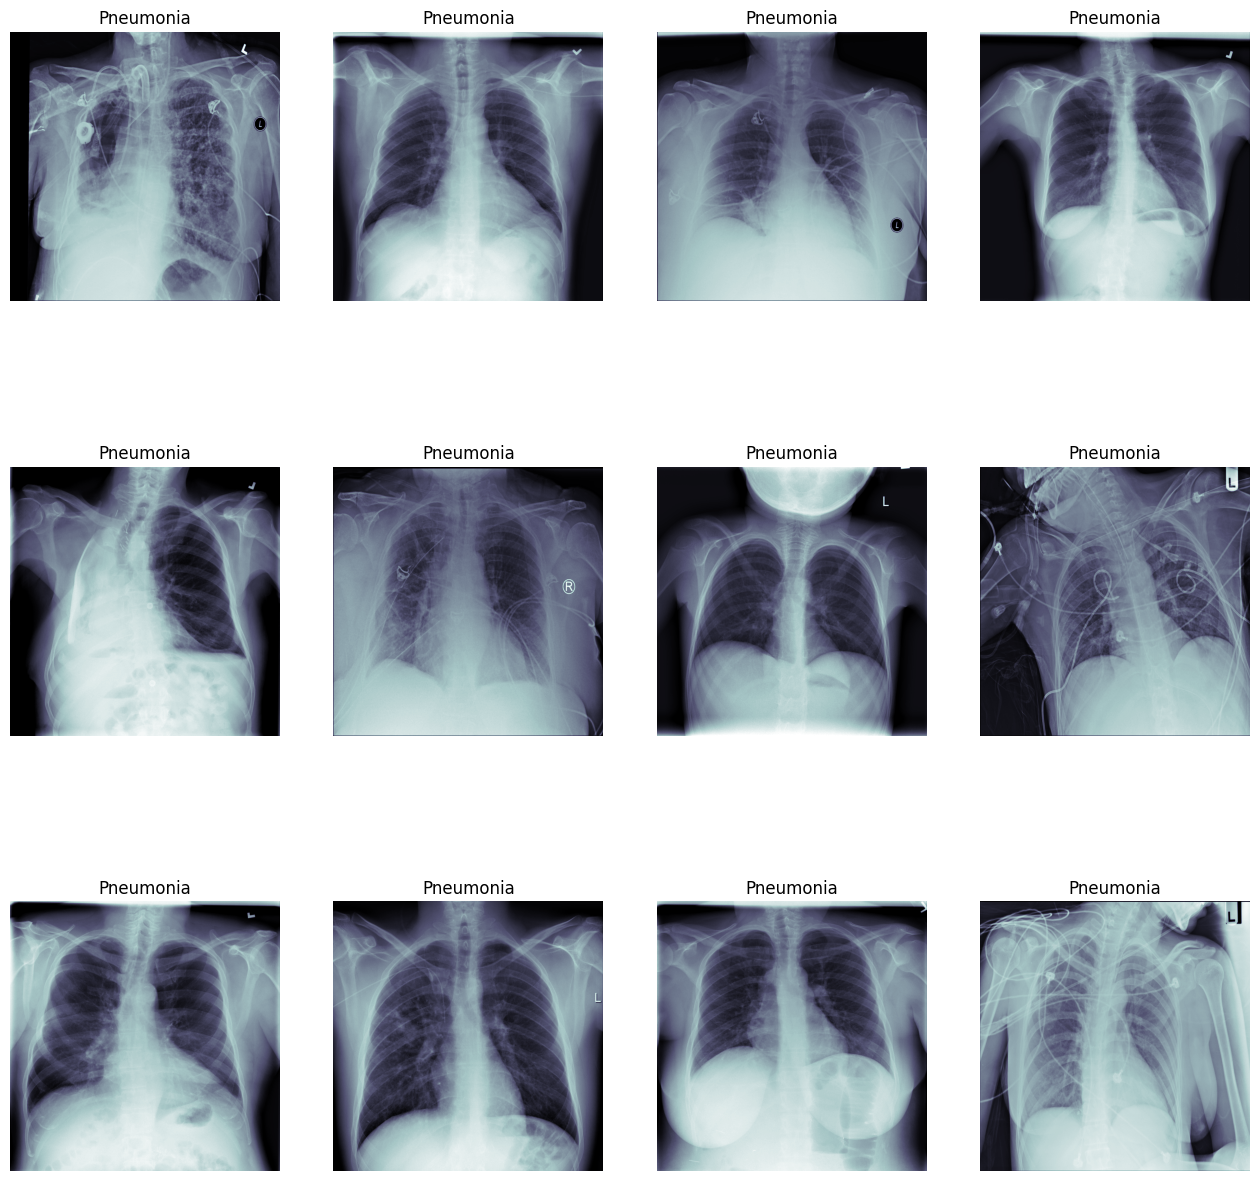

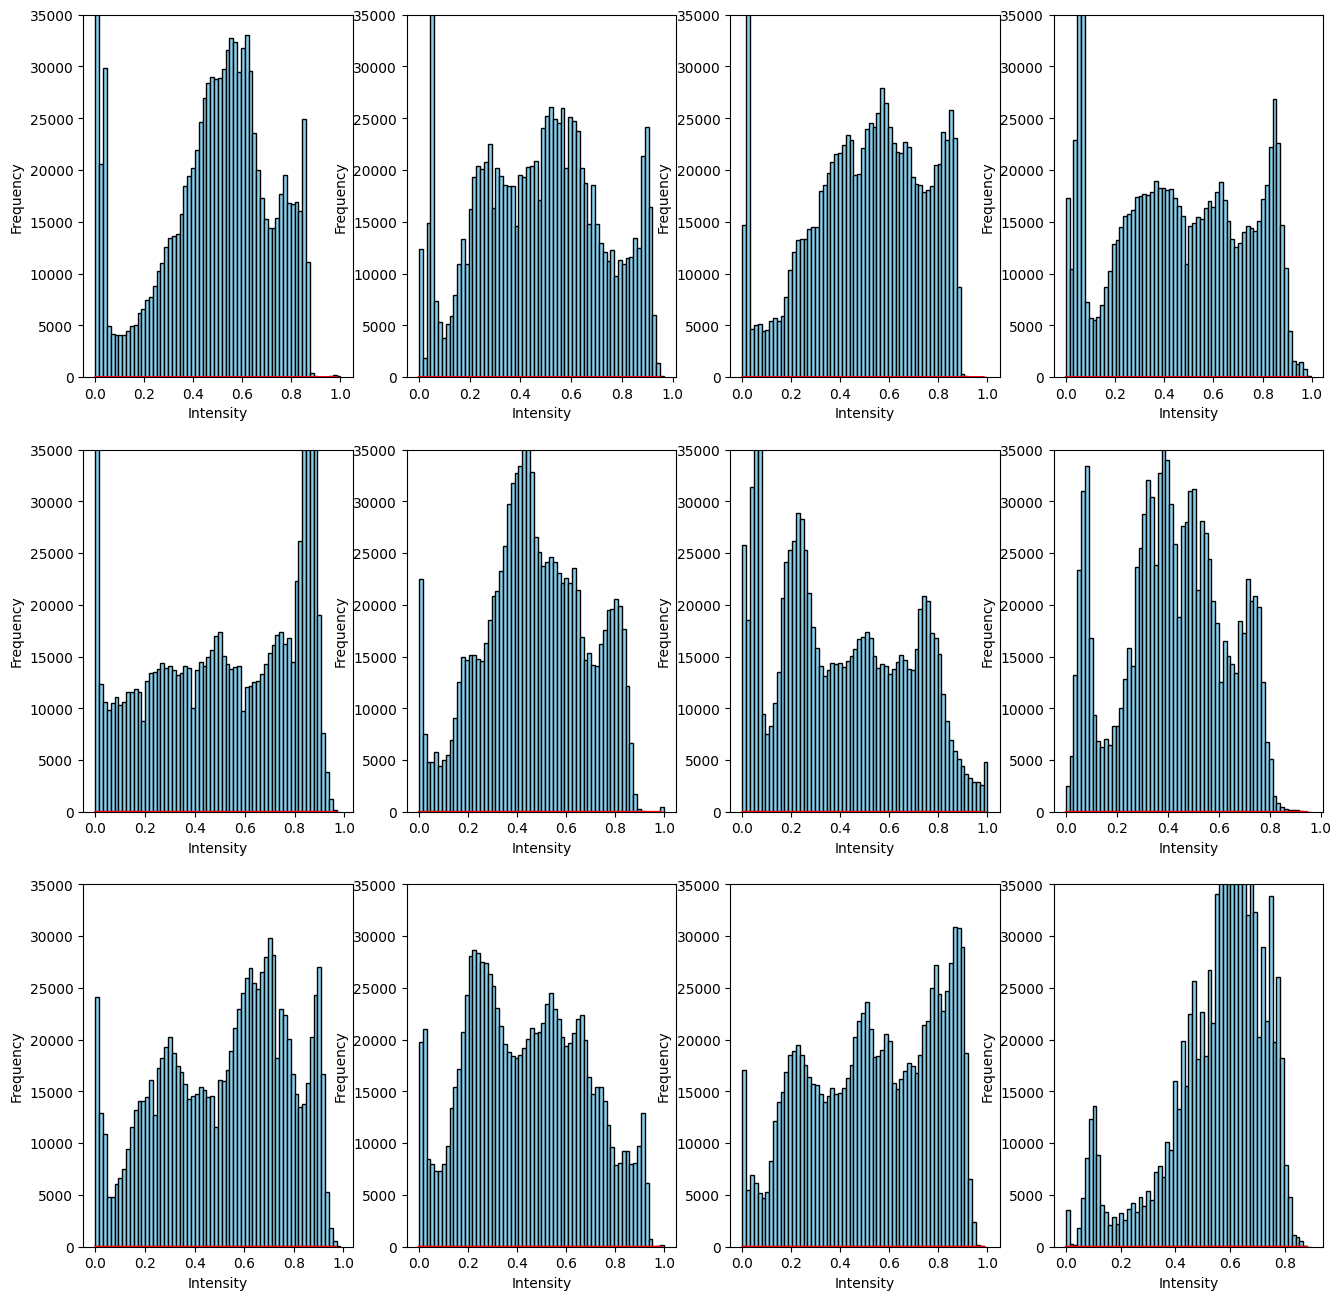

In [89]:
rows = 3
cols = 4
img_paths = sample_df[sample_df['Finding Labels'] == 'Pneumonia']['path'].sample(n=rows * cols).values

# Image Display
_, axs = plt.subplots(rows, cols, figsize=(16, 16))
axs = axs.flatten()
for img_path, ax in zip(img_paths, axs):
    img = plt.imread(img_path)
    img_normalized = img / img.max()  # Normalize the image
    ax.imshow(img_normalized, cmap='bone')  # Using 'bone' colormap
    labels = sample_df[sample_df['Image Index'] == img_path.split('/')[-1]]['Finding Labels'].values[0]
    ax.set_title(labels)
    ax.axis('off')

# Histograms
_, axs = plt.subplots(rows, cols, figsize=(16, 16))
axs = axs.flatten()
for img_path, ax in zip(img_paths, axs):
    img = plt.imread(img_path)
    img_flat = img.flatten()
    ax.hist(img_flat, bins=64, color='skyblue', edgecolor='black')  # Customized bin size and color
    density = np.histogram(img_flat, bins=64, density=True)
    ax.plot(density[1][:-1], density[0], color='red')  # Overlay density plot
    ax.set_ylim(0, 35000)
    ax.set_xlabel('Intensity')
    ax.set_ylabel('Frequency')


In [94]:

custom_palette = ['#A8A7A7', '#CC527A', '#E8175D', '#474747', '#363636']
rows = 3
cols = 4
img_paths = sample_df[sample_df['Finding Labels'] == 'Pneumonia']['path'].sample(n=rows * cols).values

stats = []

for img_path in img_paths:
    img = plt.imread(img_path)
    img_flat = img.flatten()

    # If the images are normalized (0.0 to 1.0), scale them to 0-255 and convert to integers
    if img_flat.max() <= 1.0:
        img_flat = (img_flat * 255).astype(int)
    else:
        img_flat = img_flat.astype(int)

    stats.append({
        'Mean Intensity': np.mean(img_flat),
        'Median Intensity': np.median(img_flat),
        'Standard Deviation': np.std(img_flat),
        'Mode Intensity': np.bincount(img_flat).argmax(),
        'Skewness': skew(img_flat),
        'Kurtosis': kurtosis(img_flat)
    })

stats_df = pd.DataFrame(stats)
print(stats_df)


    Mean Intensity  Median Intensity  Standard Deviation  Mode Intensity  \
0       119.866973             130.0           62.558488               0   
1       107.108478             104.0           71.773466              17   
2       120.486794             125.0           78.536872               0   
3       141.432756             151.0           43.705337             153   
4       120.647319             118.0           54.419110               0   
5       136.404331             140.0           65.818095               0   
6        98.883159              89.0           69.244387              16   
7       112.081351             110.0           60.503909               0   
8        88.196443              98.0           65.142422               0   
9       133.091370             144.0           64.857653               0   
10      114.662902             119.0           68.764937               0   
11      120.525484             124.0           63.147874              14   

    Skewnes

### Analysis 

1. **Mean Intensity:**
* Indicates the average brightness of each image.
* Values closer to 255 indicate brighter images, while values closer to 0 indicate darker images.

2. **Median Intensity:**
* This is less sensitive to extreme values than the mean and gives the midpoint of brightness in the image.
* Similar to the mean, higher values indicate brighter images.

3. **Standard Deviation:**
* Measures the variability or spread of the intensity values in each image.
* Higher values indicate a wider range of intensities (more contrast), while lower values suggest more uniform intensity.

4. **Mode Intensity:**
* Represents the most frequent intensity value in each image.
* A mode of 0 in several images suggests a significant background or dark area.

5. **Skewness:**
* Describes the asymmetry of the intensity distribution.
* Negative values indicate a distribution skewed left (towards darker intensities), and positive values indicate a skew to the right (towards brighter intensities).

6. **Kurtosis:**
* Reflects the 'tailedness' of the distribution.
* Higher kurtosis values suggest more outliers (extreme values), while lower values indicate a more uniform distribution.

There is a mix of image brightness and contrast levels among the set, as indicated by varying mean, median, and standard deviation values. The skewness and kurtosis values also suggest differences in the distribution of intensities across images, with some having more pronounced tails or asymmetry.

These insights can be particularly useful in understanding the characteristics of the images and potentially correlating them with specific clinical findings or conditions, such as the presence and severity of pneumonia. 

### Exploring No Findings through X-Ray Imaging: A Combined Visual and Histogramatic Perspective

In [97]:
rows = 4
cols = 4
img_paths = sample_df[sample_df['Pneumonia'] == 1]['path'].sample(n=rows * cols).values

# Initialize an empty list to store statistics for each image
stats = []

for img_path in img_paths:
    img = plt.imread(img_path)
    img_flat = img.flatten()

    # Scale the image intensity values if they are normalized
    if img_flat.max() <= 1.0:
        img_flat = (img_flat * 255).astype(int)
    else:
        img_flat = img_flat.astype(int)

    # Calculate and store statistics
    stats.append({
        'Mean Intensity': np.mean(img_flat),
        'Median Intensity': np.median(img_flat),
        'Standard Deviation': np.std(img_flat),
        'Mode Intensity': np.bincount(img_flat).argmax(),
        'Skewness': skew(img_flat),
        'Kurtosis': kurtosis(img_flat)
    })

# Create a DataFrame from the statistics
stats_df = pd.DataFrame(stats)

# Display the DataFrame
print(stats_df)


    Mean Intensity  Median Intensity  Standard Deviation  Mode Intensity  \
0       106.611430             112.0           67.907565               2   
1       166.438951             192.0           68.347524             229   
2       120.647319             118.0           54.419110               0   
3        88.196443              98.0           65.142422               0   
4       110.292407             114.0           26.803858             144   
5       109.407920             115.0           53.549058             178   
6       125.812456             132.0           65.930559              10   
7       104.000912             110.0           59.567912               3   
8       149.331603             163.0           62.137110               1   
9       116.732818             120.0           46.227702               3   
10       98.883159              89.0           69.244387              16   
11      120.486794             125.0           78.536872               0   
12      119.

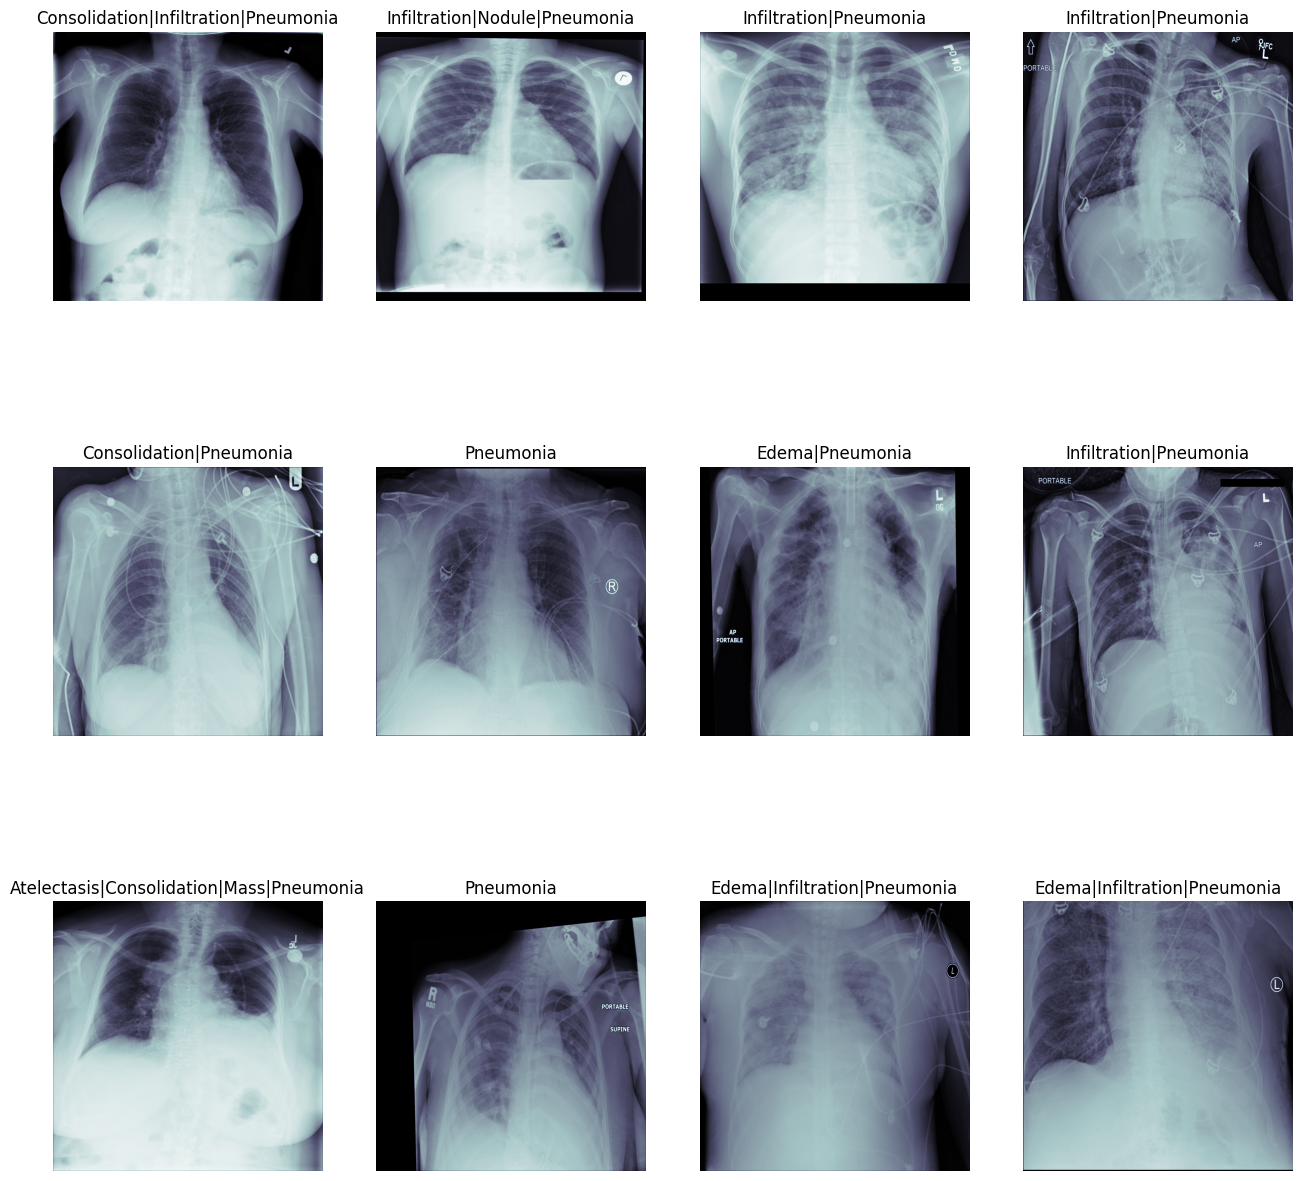

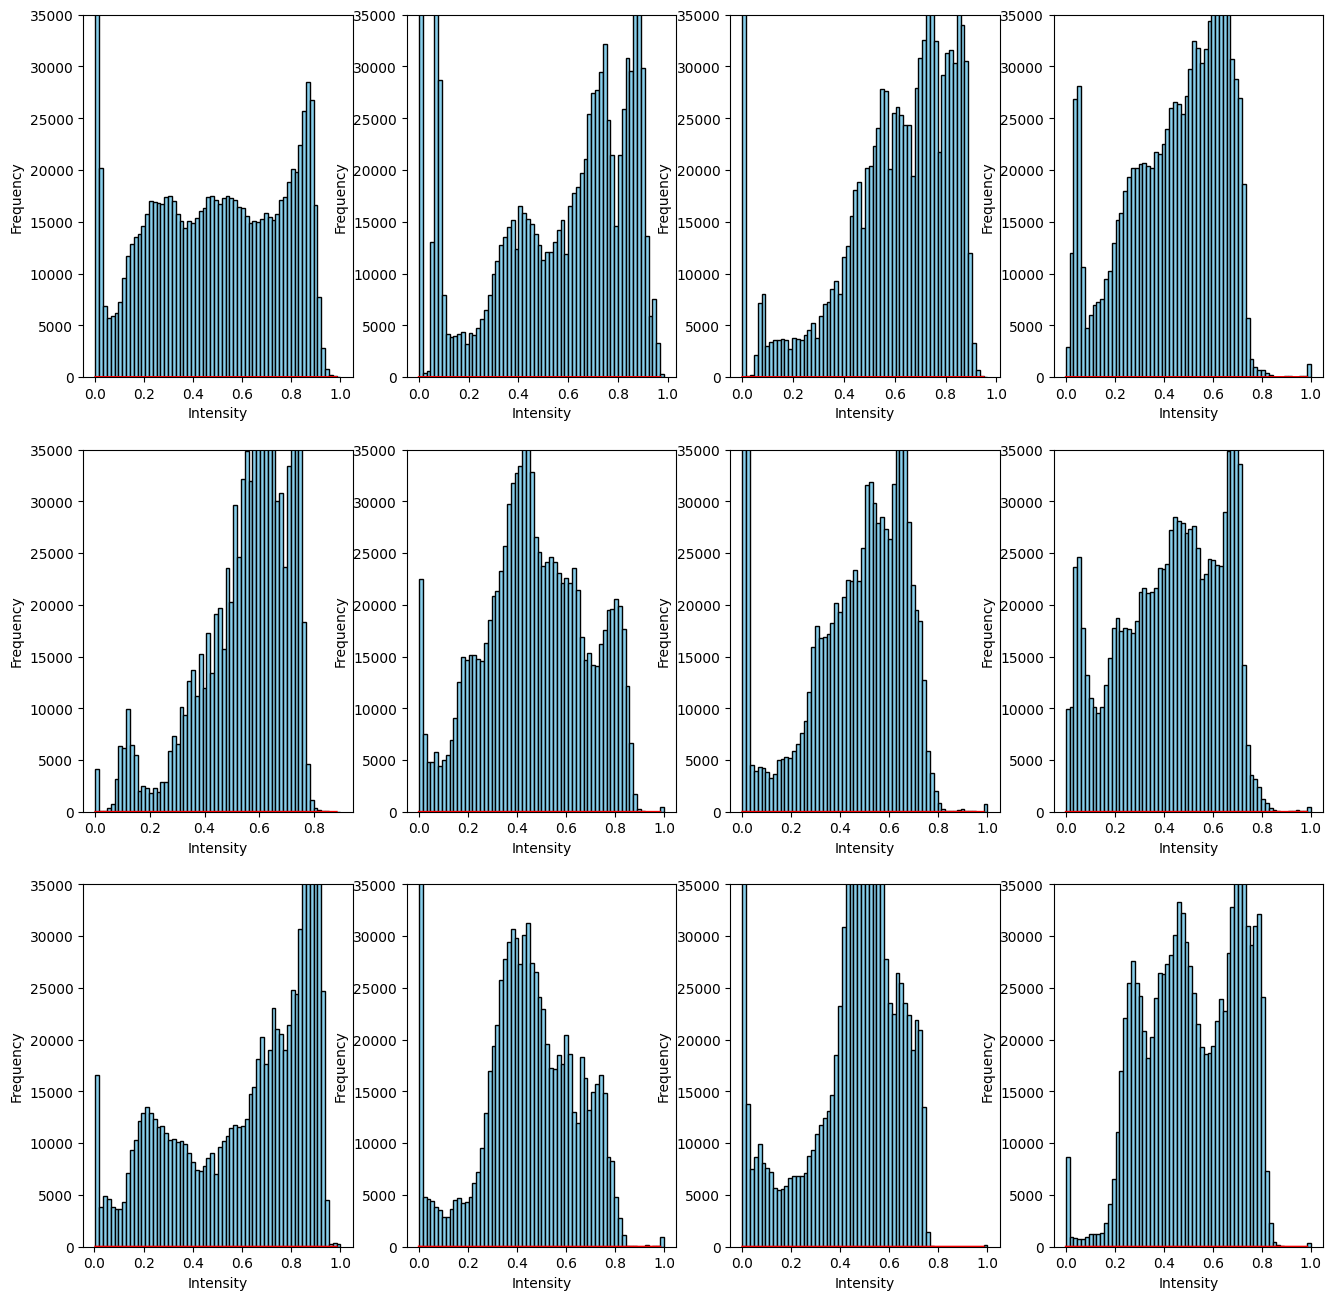

In [98]:
# Image Display
_, axs = plt.subplots(rows, cols, figsize=(16, 16))
axs = axs.flatten()
for img_path, ax in zip(img_paths, axs):
    img = plt.imread(img_path)
    img_normalized = img / img.max()  # Normalize the image
    ax.imshow(img_normalized, cmap='bone')  # Using 'bone' colormap
    labels = sample_df[sample_df['Image Index'] == img_path.split('/')[-1]]['Finding Labels'].values[0]
    ax.set_title(labels)
    ax.axis('off')

# Histograms
_, axs = plt.subplots(rows, cols, figsize=(16, 16))
axs = axs.flatten()
for img_path, ax in zip(img_paths, axs):
    img = plt.imread(img_path)
    img_flat = img.flatten()
    ax.hist(img_flat, bins=64, color='skyblue', edgecolor='black')  # Customized bin size and color
    density = np.histogram(img_flat, bins=64, density=True)
    ax.plot(density[1][:-1], density[0], color='red')  # Overlay density plot
    ax.set_ylim(0, 35000)
    ax.set_xlabel('Intensity')
    ax.set_ylabel('Frequency')


### Analysis

1. **Mean and Median Intensity:**
* These values indicate the overall brightness of the images. A higher mean or median suggests a brighter image.
* The range of these values across images may indicate varying degrees of lung opacity, which is a common feature in pneumonia.

2. **Standard Deviation:**
* This indicates the spread of intensity values. A higher standard deviation suggests more contrast in the image, possibly indicating areas of the lung that are more or less affected.

3. **Mode Intensity:**
* The most frequent intensity value in each image.
* A low mode (e.g., close to 0) often indicates a large area of dark background, while a higher mode could signify a prevalent intensity value in the lung areas, potentially related to infection.

4. **Skewness:**
* Measures the asymmetry of the intensity distribution. Negative skewness indicates a left skew (more darker pixels), and positive skewness a right skew (more lighter pixels).
* This could reflect the distribution of healthy versus affected lung tissue in the images.

5. **Kurtosis:**
* Reflects the 'tailedness' of the intensity distribution. High kurtosis means more outliers (extreme values), while low kurtosis indicates a more uniform distribution.
* Extreme values might correspond to areas of significant abnormality in the lungs.

The range of mean and median intensities, along with the standard deviations, suggest a diversity in image characteristics, possibly corresponding to varying degrees and types of lung involvement in pneumonia. The skewness and kurtosis values further support this, showing different distributions of intensity values which might correlate with different presentations of the disease.

Comparing these results with the previous set or with clinical data could provide deeper insights into how these imaging characteristics relate to clinical manifestations of pneumonia or other conditions. 

### Conclusions

In the context of medical image classification, addressing class imbalance is crucial for model performance. Common techniques like stratified sampling and class weights can be employed to tackle this issue effectively. However, to further enhance the model's ability to generalize and improve its performance, various data augmentation strategies can be considered. These techniques aim to increase the diversity of the dataset and help the model learn robust features from limited data. Some commonly used data augmentation techniques include rotation, horizontal and vertical flips, scaling, translation, brightness and contrast adjustments, Gaussian noise, elastic deformation, blur, color jitter, cropping, padding, mixup, and CutMix. Additionally, domain-specific augmentations, such as simulating different imaging modalities or introducing variations in tissue appearance, can be beneficial for medical images. Conditional augmentation based on class or diagnosis, as well as temporal augmentations for medical videos, are also worth exploring. When applying data augmentation, it's essential to strike a balance between diversity and interpretability while considering domain-specific characteristics. Libraries like OpenCV, scikit-image, Augmentor, or Albumentations can be used to implement these augmentations based on complexity of this dataset. 